<a href="https://colab.research.google.com/github/Chawlaji8781/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display 

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools  #functions that act or return other functions

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255                                #tensor is scaled between [0,1]
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:                              #If there are more that one images
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
'''
tf.keras.utils.get_file('Name of the file for saving', 'url')
'''

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [5]:
def load_img(path_to_img):
  max_dim = 512                                                  #Limiting maximum dimension of the image to 512
  img = tf.io.read_file(path_to_img)                             #Reads the Image from its path
  img = tf.image.decode_image(img, channels=3)                   #Detects the type of image(BMP, JPG, PNG, etc.) and convert it to tensor
  img = tf.image.convert_image_dtype(img, tf.float32)            #Converts pixels to float

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)                #Takes height and width as float
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]                                       #tf.newaxis creates a new dimension
  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

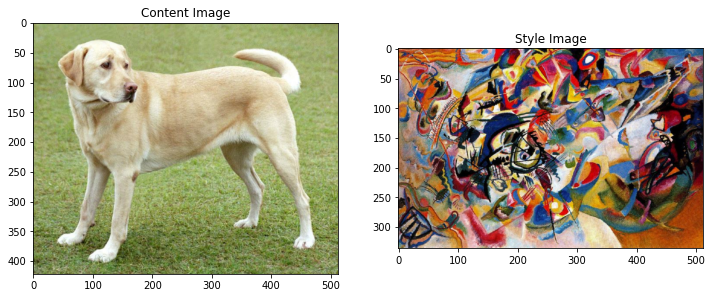

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# VGG19 

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)  #Converting RGB to BGR
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')   #Including top layers to check the correct implementation of VGG
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('Labrador_retriever', 0.49317136),
 ('golden_retriever', 0.23665282),
 ('kuvasz', 0.036357533),
 ('Chesapeake_Bay_retriever', 0.024182757),
 ('Greater_Swiss_Mountain_dog', 0.01864606)]

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')   #Top_layer is false because we are not solving the classfication model and using pre trained model for feature extraction

print()
for layer in vgg.layers:  #For printing all the layers of VGG
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*.

In [11]:
# defining the layers to be used

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Building the model

In [12]:
# Function to extract weights of the intermediate layers of vgg19

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False     #This is freezing the layers
  
  outputs = [vgg.get_layer(name).output for name in layer_names]    #vgg.get_layer returns the weights of the given layer

  model = tf.keras.Model([vgg.input], outputs)                      #tf.keras.Model takes input layer and other layers(output) and returns the model with these layers
  return model


In [13]:
# Creating the model

style_extractor = vgg_layers(style_layers)                 #returns the model with style_layers as layers
style_outputs = style_extractor(style_image*255)          

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



# Loss

The total_loss is divided into three parts.

1). Content Loss: Calculates the difference between the content (pixel values) of content image and generated image.It is used to check how much the generated image is similar to our content image. We know that the information about the content of any image will be simply given by the activations of the neurons in different layers. The deeper the layer, the more information it stores. It is simply calculated as the euclidean distance between the activations or feature representation of content and generated images at different layers. 
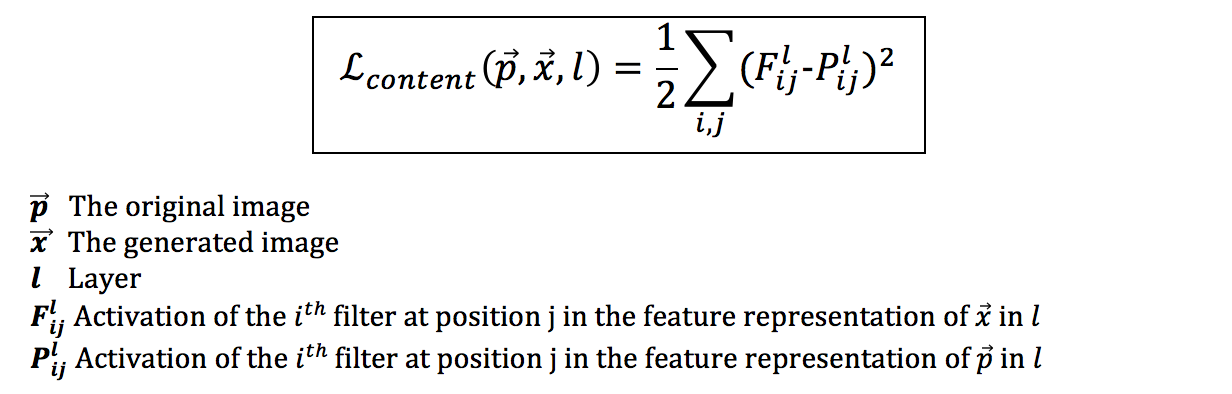



2). Style Loss: Calculates the difference between the style of content image and generated image. Style Loss is used to check how much the style of the generated image differs from the style of my style image. But the difference between both is that the style of any image is not simply represented as in the case of content. So how can we get the style representation of any image? The answer is the **Gram Matrix**.

The correlation of all channels w.r.t each other is given by the Gram Matrix of an image. We will use the Gram Matrix to measure the degree of correlation between channels which later will act as a measure of the style itself.

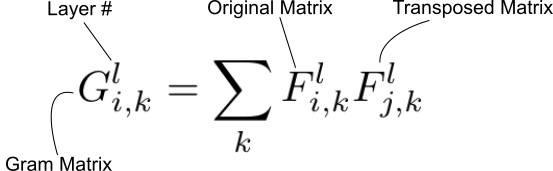

In [14]:
# Style of an image refers to the texture, the brush strokes, the geometrical shapes and the spatial colour distribution in any image.

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Initiallizing weights to style and content loss

In [15]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)      #Reduce mean computes means of elements across dimennsions of a tensor
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers                                      #division is done to get style loss per layer

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) #add_n adds input tensors element wise
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

**iii). Variation Loss:** This loss ensures spatial continuity and smoothness in the generated image to avoid noisy and overly pixelated results. This is done by finding the difference between the neighbour pixels.

In [16]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [17]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [18]:
# Initializing Weights
style_weight=1e-2
content_weight=1e4
total_variation_weight= 30

In [19]:
# Using ADAM Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [20]:
#Clipping is necessary since the model only accepts value b/w 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [21]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [22]:
image = tf.Variable(content_image)                   #Initializing the new image

Model for returning Style and Content tesors

In [23]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)     #Preprocesses the image before sending into VGG19
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [24]:
extractor = StyleContentModel(style_layers, content_layers)    #Creating an object for the class

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.5
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.36
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.879
    mean:  13.764149


In [25]:
style_targets = extractor(style_image)['style']                      #Holds Style of Style Image
content_targets = extractor(content_image)['content']                #Holds Content of Content Image

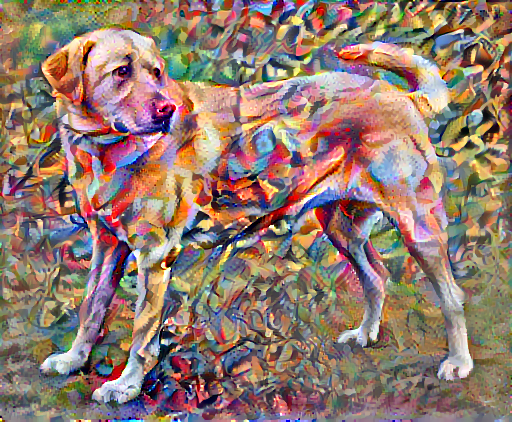

Train step: 1000
Total time: 75.4


In [26]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

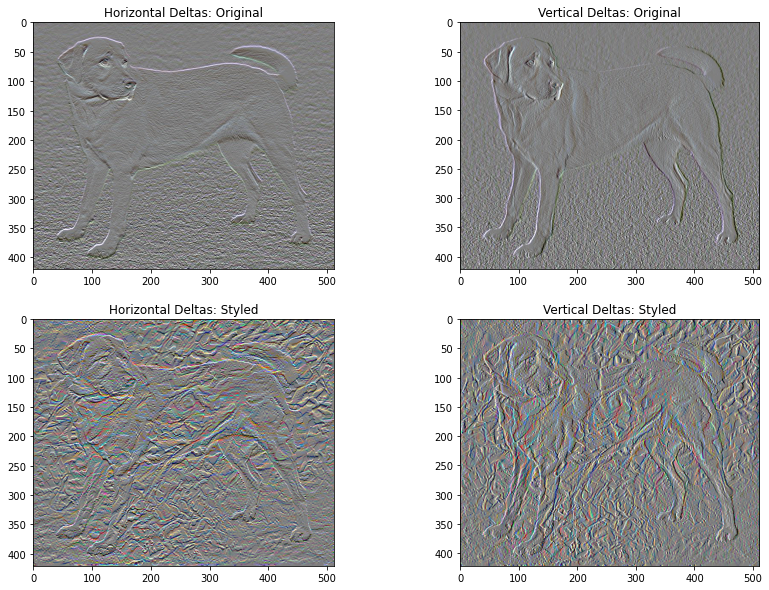

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [28]:
total_variation_loss(image).numpy()

69448.05

# Saving the result

In [29]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>